# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03433997, -0.22645559,  0.01813097,  0.31026334]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.4267734155990794 -2.869151689960236


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    return states, actions

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                     labels=actions_labels))        
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [31]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 16               # number of units in each Q-network hidden layer -- simulation

In [32]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [33]:
env.reset()

array([ 0.00227515,  0.01545863, -0.0344419 , -0.01956395])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [34]:
state, reward, action

(array([-0.17996974, -1.77529772,  0.23355462,  2.84581555]), 1.0, 0.0)

In [38]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            action *= 1 - float(done) # last action is always 0
            #if done is True: action = 0 # 0, 1 but 2 means the end
            batch.append([state, action, done])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                 model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode: 0 Total reward: 10.0 Batch loss: 0.600409329
Episode: 1 Total reward: 9.0 Batch loss: 0.605263412
Episode: 2 Total reward: 9.0 Batch loss: 0.606427431
Episode: 3 Total reward: 9.0 Batch loss: 0.596562207
Episode: 4 Total reward: 10.0 Batch loss: 0.570870519
Episode: 5 Total reward: 10.0 Batch loss: 0.572111487
Episode: 6 Total reward: 10.0 Batch loss: 0.561078072
Episode: 7 Total reward: 10.0 Batch loss: 0.556855381
Episode: 8 Total reward: 10.0 Batch loss: 0.548258543
Episode: 9 Total reward: 9.0 Batch loss: 0.561778367
Episode: 10 Total reward: 11.0 Batch loss: 0.517352343
Episode: 11 Total reward: 10.0 Batch loss: 0.535184264
Episode: 12 Total reward: 8.0 Batch loss: 0.561268091
Episode: 13 Total reward: 11.0 Batch loss: 0.493543237
Episode: 14 Total reward: 9.0 Batch loss: 0.530371904
Episode: 15 Total reward: 10.0 Batch loss: 0.517161965
Episode: 16 Total reward: 8.0 Batch loss: 0.555670381
Episode: 17 Total reward: 10.0 Batch loss: 0.507343113
Episode: 18 Total reward: 8

Episode: 172 Total reward: 10.0 Batch loss: 0.127545074
Episode: 173 Total reward: 10.0 Batch loss: 0.126464695
Episode: 174 Total reward: 10.0 Batch loss: 0.120583631
Episode: 175 Total reward: 9.0 Batch loss: 0.134846359
Episode: 176 Total reward: 8.0 Batch loss: 0.167986020
Episode: 177 Total reward: 11.0 Batch loss: 0.120222710
Episode: 178 Total reward: 9.0 Batch loss: 0.132035136
Episode: 179 Total reward: 9.0 Batch loss: 0.133754626
Episode: 180 Total reward: 9.0 Batch loss: 0.129888475
Episode: 181 Total reward: 9.0 Batch loss: 0.137384206
Episode: 182 Total reward: 10.0 Batch loss: 0.116963170
Episode: 183 Total reward: 10.0 Batch loss: 0.113533095
Episode: 184 Total reward: 9.0 Batch loss: 0.125222206
Episode: 185 Total reward: 9.0 Batch loss: 0.136067569
Episode: 186 Total reward: 10.0 Batch loss: 0.121716775
Episode: 187 Total reward: 10.0 Batch loss: 0.111367069
Episode: 188 Total reward: 10.0 Batch loss: 0.117768288
Episode: 189 Total reward: 10.0 Batch loss: 0.111529425


Episode: 323 Total reward: 21.0 Batch loss: 0.186799929
Episode: 324 Total reward: 24.0 Batch loss: 0.181282356
Episode: 325 Total reward: 23.0 Batch loss: 0.366463870
Episode: 326 Total reward: 23.0 Batch loss: 0.370994747
Episode: 327 Total reward: 20.0 Batch loss: 0.181379750
Episode: 328 Total reward: 24.0 Batch loss: 0.191602662
Episode: 329 Total reward: 24.0 Batch loss: 0.189390764
Episode: 330 Total reward: 22.0 Batch loss: 0.162032694
Episode: 331 Total reward: 28.0 Batch loss: 0.170761734
Episode: 332 Total reward: 20.0 Batch loss: 0.171260566
Episode: 333 Total reward: 28.0 Batch loss: 0.176482603
Episode: 334 Total reward: 25.0 Batch loss: 0.192277968
Episode: 335 Total reward: 26.0 Batch loss: 0.164550304
Episode: 336 Total reward: 21.0 Batch loss: 0.191856548
Episode: 337 Total reward: 31.0 Batch loss: 0.178403422
Episode: 338 Total reward: 29.0 Batch loss: 0.176825225
Episode: 339 Total reward: 26.0 Batch loss: 0.147690311
Episode: 340 Total reward: 25.0 Batch loss: 0.15

Episode: 469 Total reward: 200.0 Batch loss: 0.297375113
Episode: 470 Total reward: 200.0 Batch loss: 0.318243891
Episode: 471 Total reward: 200.0 Batch loss: 0.308729172
Episode: 472 Total reward: 200.0 Batch loss: 0.108964004
Episode: 473 Total reward: 200.0 Batch loss: 0.300302118
Episode: 474 Total reward: 200.0 Batch loss: 0.203669325
Episode: 475 Total reward: 181.0 Batch loss: 0.052658536
Episode: 476 Total reward: 200.0 Batch loss: 0.304507613
Episode: 477 Total reward: 197.0 Batch loss: 0.102146722
Episode: 478 Total reward: 200.0 Batch loss: 0.201627165
Episode: 479 Total reward: 200.0 Batch loss: 0.300360888
Episode: 480 Total reward: 200.0 Batch loss: 0.232046425
Episode: 481 Total reward: 200.0 Batch loss: 0.304323077
Episode: 482 Total reward: 200.0 Batch loss: 0.185441405
Episode: 483 Total reward: 200.0 Batch loss: 0.296455652
Episode: 484 Total reward: 200.0 Batch loss: 0.362355083
Episode: 485 Total reward: 200.0 Batch loss: 0.203146845
Episode: 486 Total reward: 200.

Episode: 613 Total reward: 200.0 Batch loss: 0.351718187
Episode: 614 Total reward: 200.0 Batch loss: 0.258091539
Episode: 615 Total reward: 200.0 Batch loss: 0.238441244
Episode: 616 Total reward: 200.0 Batch loss: 0.291061819
Episode: 617 Total reward: 200.0 Batch loss: 0.280543506
Episode: 618 Total reward: 200.0 Batch loss: 0.237483695
Episode: 619 Total reward: 200.0 Batch loss: 0.301777750
Episode: 620 Total reward: 200.0 Batch loss: 0.250546098
Episode: 621 Total reward: 200.0 Batch loss: 0.241341040
Episode: 622 Total reward: 200.0 Batch loss: 0.302007139
Episode: 623 Total reward: 200.0 Batch loss: 0.167679369
Episode: 624 Total reward: 200.0 Batch loss: 0.296506882
Episode: 625 Total reward: 200.0 Batch loss: 0.361241519
Episode: 626 Total reward: 200.0 Batch loss: 0.296582878
Episode: 627 Total reward: 200.0 Batch loss: 0.274778217
Episode: 628 Total reward: 200.0 Batch loss: 0.057942625
Episode: 629 Total reward: 200.0 Batch loss: 0.313147843
Episode: 630 Total reward: 200.

Episode: 758 Total reward: 200.0 Batch loss: 0.321008414
Episode: 759 Total reward: 200.0 Batch loss: 0.265076011
Episode: 760 Total reward: 200.0 Batch loss: 0.294384718
Episode: 761 Total reward: 200.0 Batch loss: 0.341448635
Episode: 762 Total reward: 200.0 Batch loss: 0.322642982
Episode: 763 Total reward: 200.0 Batch loss: 0.343596280
Episode: 764 Total reward: 200.0 Batch loss: 0.268282473
Episode: 765 Total reward: 200.0 Batch loss: 0.275171846
Episode: 766 Total reward: 200.0 Batch loss: 0.349032372
Episode: 767 Total reward: 200.0 Batch loss: 0.331448793
Episode: 768 Total reward: 200.0 Batch loss: 0.249274641
Episode: 769 Total reward: 200.0 Batch loss: 0.277571321
Episode: 770 Total reward: 200.0 Batch loss: 0.269396931
Episode: 771 Total reward: 200.0 Batch loss: 0.348243207
Episode: 772 Total reward: 200.0 Batch loss: 0.349726588
Episode: 773 Total reward: 200.0 Batch loss: 0.293939888
Episode: 774 Total reward: 200.0 Batch loss: 0.249310166
Episode: 775 Total reward: 200.

Episode: 903 Total reward: 200.0 Batch loss: 0.269349813
Episode: 904 Total reward: 200.0 Batch loss: 0.199217707
Episode: 905 Total reward: 200.0 Batch loss: 0.279077351
Episode: 906 Total reward: 200.0 Batch loss: 0.332063824
Episode: 907 Total reward: 200.0 Batch loss: 0.269814283
Episode: 908 Total reward: 200.0 Batch loss: 0.321425796
Episode: 909 Total reward: 200.0 Batch loss: 0.257079840
Episode: 910 Total reward: 200.0 Batch loss: 0.259135097
Episode: 911 Total reward: 200.0 Batch loss: 0.278316259
Episode: 912 Total reward: 200.0 Batch loss: 0.335842311
Episode: 913 Total reward: 200.0 Batch loss: 0.276040673
Episode: 914 Total reward: 200.0 Batch loss: 0.266704351
Episode: 915 Total reward: 200.0 Batch loss: 0.271484882
Episode: 916 Total reward: 200.0 Batch loss: 0.279822171
Episode: 917 Total reward: 200.0 Batch loss: 0.241078630
Episode: 918 Total reward: 200.0 Batch loss: 0.305767357
Episode: 919 Total reward: 200.0 Batch loss: 0.326439768
Episode: 920 Total reward: 200.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

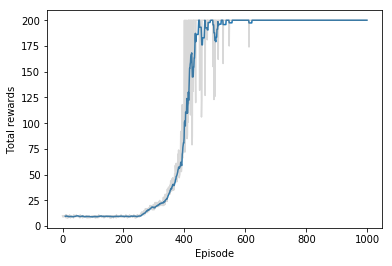

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

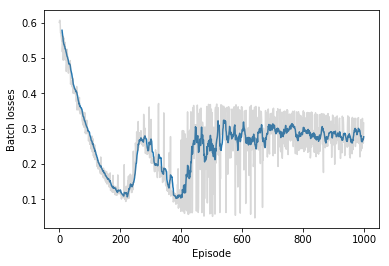

In [41]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.